<a href="https://colab.research.google.com/github/yupopov/stepik_ml_contest/blob/master/main_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stepik ml contest

Задача с курса [Введение в Data Science и машинное обучение](https://stepik.org/course/4852): для посетителей онлайн-курса "Анализ данных в R" по логам их активности за первые два дня на курсе предсказать, смогут ли они его успешно закончить. Считается, что пользователь прошел курс, если за все время пребывания на нем он смог решить больше 40 задач.

Ответом для каждого пользователя является оценка вероятности успешного завершения им курса, оценка качества осуществляется по метрике ROC-AUC.

Для решения задачи были применены древесные модели (random forest, xgboost), которые показали примерно одинаковое качество (финальный скор = 0.889), но случайный лес оказался проще в настройке.

Если интерпретировать получившуюся модель, то получается, что самым важным признаком является количество правильных решений задач за первые два дня (то есть, если пользователь много решает задачи в первые два дня, то скорее всего, и в остальное время время на курсе тоже будет решать много задач, кто бы мог подумать). Однако, в получившемся датасете присутствует много коррелирующих признаков, что усложняло интерпретацию модели и отбор признаков для этой задачи.

Скорее всего, модель можно улучшить добавлением данных, как о новых пользователях, что видно на кривых обучения, так и расширением временного окна (например, брать действия за первых три дня) — видимо, есть какое-то количество пользователей, которые записываются на курс, сразу же его бросают и проходят только через некоторое время. Таких пользователей мы никак отловить не можем.




In [1]:
# Для запуска на colab
!git clone https://github.com/yupopov/stepik_ml_contest
import os
os.chdir('stepik_ml_contest')

Cloning into 'stepik_ml_contest'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 56 (delta 21), reused 42 (delta 11), pack-reused 0
Unpacking objects: 100% (56/56), done.


In [2]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.cluster import hierarchy

from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix

from config.config import TOTAL_DAYS, PATH_TO_DATA, RANDOM_STATE
# рассматриваем данные за первые TOTAL_DAYS дней активности
from utils.df_creation import get_users, create_interaction, get_target, get_min_timestamps,\
    cut_df_by_time, cut_dfs_by_time, get_action_counts_by_period, get_base_features
from utils.model_assessment import test_model, plot_learning_curve, plot_validation_curve

# Загрузка данных и sanity checks

Загрузим данные с действиями и попытками решений задач.

In [7]:
events = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_train.zip'))
submissions = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_train.zip'))

events_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_test.zip'))
submissions_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_test.zip'))

events['time'] = pd.to_datetime(events.timestamp, unit='s')
submissions['time'] = pd.to_datetime(submissions.timestamp, unit='s')

events_test['time'] = pd.to_datetime(events_test.timestamp, unit='s')
submissions_test['time'] = pd.to_datetime(submissions_test.timestamp, unit='s')


In [8]:
events.head()

,step_id,timestamp,action,user_id,time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [9]:
submissions.head()

,step_id,timestamp,submission_status,user_id,time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [10]:
events.isna().sum()

step_id      0
timestamp    0
action       0
user_id      0
time         0
dtype: int64

In [11]:
submissions.isna().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
time                 0
dtype: int64

Проверим, какие варианты действий есть.

In [12]:
print(events.action.unique())
print(submissions.submission_status.unique())

['viewed' 'passed' 'discovered' 'started_attempt']
['correct' 'wrong']


Данные в тренировочной и тестовой выборках разделены по времени:

In [13]:
events.time.min(), events.time.max()

(Timestamp('2015-06-15 04:00:48'), Timestamp('2018-05-19 23:33:31'))

In [14]:
submissions.time.min(), submissions.time.max()

(Timestamp('2015-06-15 04:02:24'), Timestamp('2018-05-19 23:07:07'))

In [15]:
events_test.time.min(), events_test.time.max()

(Timestamp('2018-05-20 03:59:01'), Timestamp('2019-01-20 17:00:43'))

In [16]:
submissions_test.time.min(), submissions_test.time.max()

(Timestamp('2018-05-20 07:07:49'), Timestamp('2019-01-20 16:53:38'))

И по пользователям тоже:

In [17]:
np.intersect1d(events.user_id.unique(), events_test.user_id.unique())

array([], dtype=int64)

Нет пользователей без ивентов, но с сабмитами:

In [18]:
np.setdiff1d(submissions['user_id'].values, events['user_id'].values)

array([], dtype=int64)

In [19]:
np.setdiff1d(submissions_test['user_id'].values, events_test['user_id'].values)

array([], dtype=int64)

Проверим, что множества степов в тренировочной и тестовой выборке совпадают:

In [20]:
print(np.setdiff1d(events.step_id.unique(), events_test.step_id.unique()))
print(np.setdiff1d(events_test.step_id.unique(), events.step_id.unique()))

[]
[]


In [21]:
print(np.setdiff1d(submissions.step_id.unique(), submissions_test.step_id.unique()))
print(np.setdiff1d(submissions_test.step_id.unique(), submissions.step_id.unique()))

[33676 33681 33686 33734 33983 33984 34041]
[]


Есть различия, но можно посмотреть, что в каждом из этих степов довольно мало действий. Видимо, это одни из последних задач на курсе, которые просто никто не успел решить за два дня от начала курса.

In [22]:
events_test.query('step_id == 34041')

,step_id,timestamp,action,user_id,time
738,34041,1527052678,viewed,12684,2018-05-23 05:17:58
739,34041,1527052679,started_attempt,12684,2018-05-23 05:17:59
740,34041,1527052678,discovered,12684,2018-05-23 05:17:58
31872,34041,1530847853,viewed,1459,2018-07-06 03:30:53
31873,34041,1530847853,started_attempt,1459,2018-07-06 03:30:53
31874,34041,1530847853,discovered,1459,2018-07-06 03:30:53
36797,34041,1532610539,viewed,1800,2018-07-26 13:08:59
36798,34041,1532610536,started_attempt,1800,2018-07-26 13:08:56
36799,34041,1532610539,discovered,1800,2018-07-26 13:08:59
51442,34041,1537030758,viewed,24169,2018-09-15 16:59:18


In [23]:
strange_problems = np.setdiff1d(submissions.step_id.unique(), submissions_test.step_id.unique())
all('started_attempt' in events_test.query('step_id == @step').action.unique() for step in strange_problems)

True

# Создание датасетов, анализ базовых признаков

Для каждого пользователя будем рассматривать только первые двое суток его активности, как указано в условии. В курсе предлагается получить все активности в течение двух суток после первого действия в каждой таблице, что не совсем корректно, так как между первым действием пользователя (например, просмотром не задачного шага)  и первой попыткой решения задачи может пройти достаточно много времени и в этом случае мы будем брать данные из будущего. Поэтому мы объединяем две таблицы в одну и берем первые двое суток после первого действия.

In [24]:
events_2d, submissions_2d = cut_dfs_by_time(events, submissions)
events_test, submissions_test_2d = cut_dfs_by_time(events_test, submissions_test)

all_actions_2d = create_interaction(events_2d, submissions_2d)
all_actions_test = create_interaction(events_test, submissions_test)

all_actions_2d.head()

,step_id,timestamp,action,user_id,time
1596009,31981,1472827464,discovered,1,2016-09-02 14:44:24
1596008,31981,1472827464,viewed,1,2016-09-02 14:44:24
3040121,32815,1514383364,discovered,2,2017-12-27 14:02:44
3040123,32815,1514383364,passed,2,2017-12-27 14:02:44
3040122,32815,1514383364,viewed,2,2017-12-27 14:02:44


In [25]:
all(pd.Series(['discovered', 'passed', 'started_attempt', 'viewed', 'correct', 'wrong']).isin(all_actions_2d.action.unique()))

True

Посчитаем целевую переменную: будем считать, что пользователь прошел курс, если правильно решил 40 задач (можно поменять критерии, смотри докстринг к функции ```get_target```). Целевая переменная несбалансированная, но в рамках приличия.

In [26]:
targets = get_target(create_interaction(events, submissions))
targets.value_counts()

passed_course
0                17269
1                 1965
dtype: int64

Создадим таблицу с базовыми признаками для каждого пользователя, посчитав общее количество всех действий для него и количество уникальных дней, которые пользователь был на курсе.

In [30]:
train_df_base = get_base_features(all_actions_2d)
test_df_base = get_base_features(all_actions_test)

train_df_base.head()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
1,1,0,0,1,0,0,1
2,9,9,2,9,2,0,1
3,15,15,4,20,4,4,1
5,1,1,0,1,0,0,1
7,1,1,0,1,0,0,1


Посмотрим на корреляцию между базовыми признаками:

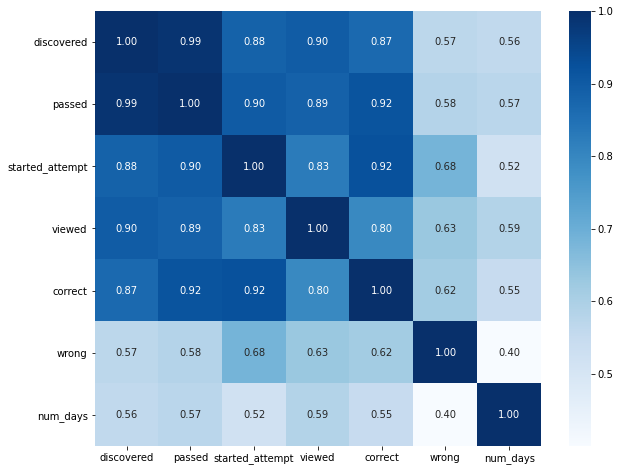

In [28]:
plt.figure(figsize = (10, 8)) 
sns.heatmap(train_df_base.corr('pearson'), annot=True, fmt='.2f', cmap='Blues');

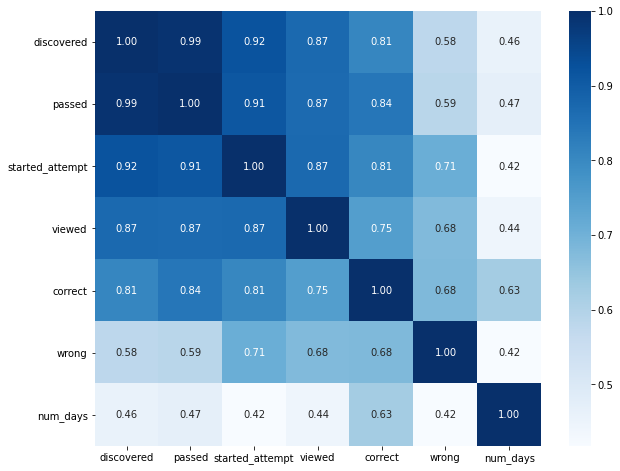

In [29]:
plt.figure(figsize = (10, 8)) 
sns.heatmap(test_df_base.corr('pearson'), annot=True, fmt='.2f', cmap='Blues');

Признаки сильно коррелируют между собой, так что лучше не использовать для решения этой задачи линейные модели и добавлять побольше регуляризации. Посмотрим простые статистики тренировочной и тестовой выборок:

In [30]:
train_df_base.describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000,19234.000000
mean,12.364875,11.407040,4.109754,19.232973,3.163201,2.840023,1.343298
std,18.037964,16.814163,8.034247,32.075203,6.306553,9.082522,0.625138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,6.000000,5.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,16.000000,14.000000,5.000000,23.750000,2.000000,1.000000,2.000000
max,198.000000,198.000000,135.000000,568.000000,76.000000,184.000000,3.000000


In [31]:
test_df_base.describe()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
count,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000,6184.000000
mean,10.877749,10.083603,4.344599,19.126132,3.407988,3.425938,1.403461
std,17.601541,16.496344,9.096022,41.319291,6.659283,11.670902,0.713354
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
50%,2.000000,2.000000,1.000000,3.000000,0.000000,0.000000,1.000000
75%,12.000000,11.000000,4.000000,17.000000,2.000000,1.000000,2.000000
max,180.000000,151.000000,113.000000,543.000000,46.000000,166.000000,6.000000


Видим, что некоторые значения отличаются, чаще всего в тренировочной выборке больше. Разницу в максимальных значениях можно списать на то, что тренировочная выборка просто больше, но вообще странно. Также видим, что бывают пользователи, у которых по нулям значения ```discovered``` и ```viewed```, что противоречит интуитивному пониманию семантики признаков. В соседней тетрадке попробуем разобраться с этим и понять, существенно ли это для нашей задачи (вроде бы, не очень).

## Решение на базовом датасете

Получим бейзлайн решение на простых признаках.

Будем использовать древесные модели, потому что признаки сильно между собой коррелируют.

Как метрику качества будем использовать ROC-AUC, потому что она и указана на степике, ну и датасет не сильно несбалансированный.

Будем считать метрики на тренировочной и валидационной выборках (```test_size = 0.1```), а также смотреть оценки и значимости признаков (нативные ```feature_importances_``` из sklearn, я не знаю метода, который бы правильно оценивал значимости признаков, когда они коррелируют) на кросс-валидации. 

ROC-AUC на тренировочной выборке:	 0.8965337720123141
ROC-AUC на валидационной выборке:	 0.8098945091250047

Mean CV score: 0.8328974649793466
Std of CV scores: 0.01319577305018126


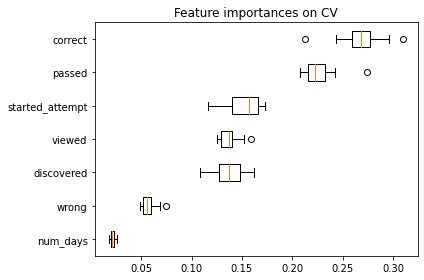

In [31]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=10,
    min_samples_split=10,
    class_weight='balanced',
    n_jobs=-1 
)

test_model(rf, train_df_base, targets, random_state=None, cv=10)

Если прогнать эту функцию несколько раз, то можно увидеть, что метрика качества модели сильно отличается на тренировочной и тестовой выборках, а также сильно зависит от разбиения выборок. Помимо этого, базовые признаки сильно коррелируют между собой, что тоже должно сказываться на устойчивости модели. Короче говоря, текущая модель переобучается, на кривой обучения это хорошо видно:

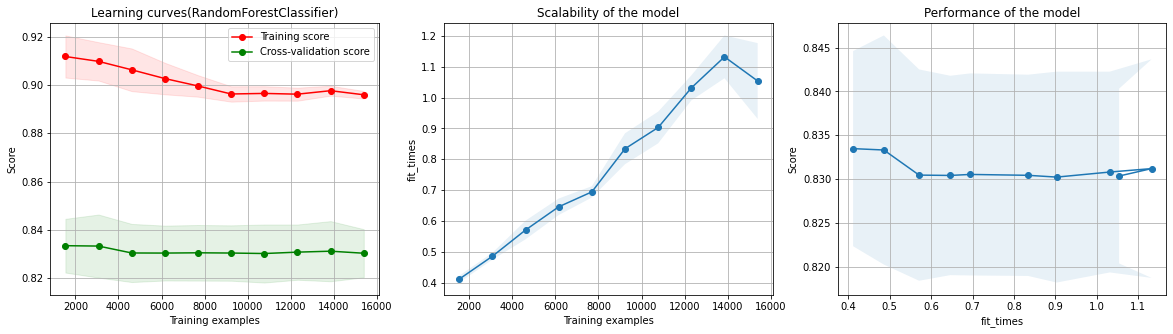

In [ ]:
plot_learning_curve(rf, train_df_base, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

Так что нужно регуляризировать модель, то есть, подобрать гиперпараметры на кросс-валидации и, возможно, сделать какой-то отбор признаков.

И то и другое здесь можно просто руками сделать, немного и параметров и признаков. Самым важным гиперпараметром оказывается максимальная глубина деревьев, что видно на кривой валидации:

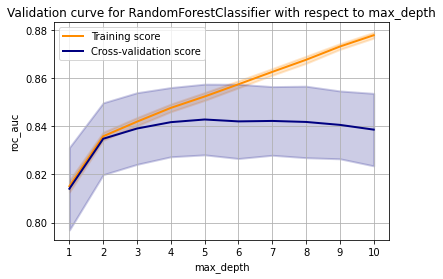

In [ ]:
plot_validation_curve(rf, train_df_base, targets, param_name='max_depth', param_range=range(1, 11), scoring='roc_auc', cv=10, n_jobs=-1)

Другие гиперпараметры особенно менять картину не будут, для стабильности поставим побольше деревьев. Признаки можно отобрать руками и увидеть, что выкидывание ```discovered``` и ```viewed``` не ухудшает модель.

ROC-AUC на тренировочной выборке:	 0.8497610983753845
ROC-AUC на валидационной выборке:	 0.8212710048527566

Mean CV score: 0.8426530479394329
Std of CV scores: 0.014074110754588521


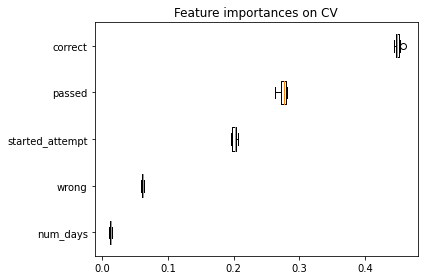

In [ ]:
rf.max_depth = 4
rf.n_estimators = 200
rf.min_samples_leaf = 30
rf.min_samples_split = 70
rf.class_weight = 'balanced'
test_model(rf, train_df_base.drop(columns=['discovered', 'viewed']), targets, cv=10)

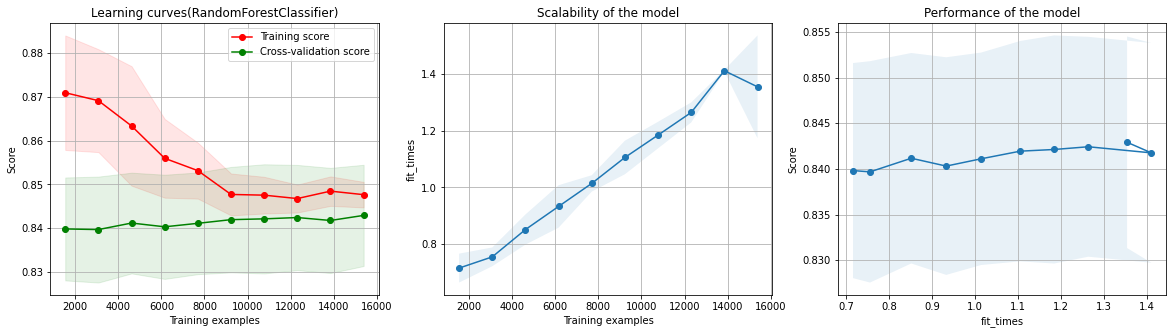

In [ ]:
plot_learning_curve(rf, train_df_base.drop(columns=['discovered', 'viewed']), targets,
                    scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

Ну вот, модель стала стабильнее, разбросы оценок и значимостей переменных уменьшились. 

Попробуем добавить в модель еще признаков.

# Построение и отбор признаков

Сгенерируем признаки, которые должны отличать людей, которые пройдут курс от тех, которые не пройдут и проверим, действительно ли добавление их улучшает модель.

Можно выделить два (пересекающихся) типа поведения в первые два дня, при которых можно сделать вывод, что участник курса покидает его:

1. Пришел на курс, быстро понял, что "не его", и ушел. Это можно описать, например, следующими признаками:
- Большая разница между активностями в первый и во второй день (функция ```get_actions_difference```)
- Общее число часов, которые пользователь провел на курсе (функция ```get_hour_features```)
- Число степов и задач, с которыми пользователь взаимодействовал (функция ```get_step_count```)
- Прошел ли пользователь дальше первых степов (функция ```get_last_action_features```)
- Общее количество действий пользователя на курсе (функция ```get_custom_features```)


2. Пришел на курс, попробовал решать задачи, понял, что не получается, и ушел. Это можно описать, например, следующими признаками:
- Получилось ли решить сложные задачи (функция ```get_step_ohe_features```) 
- Число неудачных решений задач (```started_attempt - correct```)
- Процент удачных решений (функция ```get_correct_ratio```)
- Число просмотренных, но не пройденных задач (функция ```get_custom_features```)


## Пользователи, которые быстро ушли

Сгенерируем признак, который будет считать разность в общем количестве действий между первыми и вторыми сутками пользователя на курсе.

Действия пользователей часто логируются неправильно (например, много случаев, когда записываются сотни действий в минуту, более подробный анализ можно посмотреть в соседней тетрадке), поэтому лучше всего брать промежуток длиной в сутки: на нем всплески активности не так заметны.


In [27]:
def get_actions_difference(actions_df):
  """
  Получить разницу между количеством действий пользователей
  во вторые и в первые сутки активности.

  Parameters
  ----------
  actions_df : pd.Dataframe
      данные со всеми действиями и сабмитами пользователей
  """
  actions_by_day = get_action_counts_by_period(actions_df, period_len=24, sum_only=True, drop_periods=True)
  return (actions_by_day.iloc[:, 1] - actions_by_day.iloc[:, 0]).to_frame().rename(columns={0: 'act_diff_day'})

Посчитаем, сколько часов пользователи присутствовали на курсе (отдельно для всех действий вообще и сабмитов заданий).

In [28]:
def get_unique_hours(actions_df, feature_name):
    """
    Посчитать количество уникальных часов
    в таблице `actions_df` для каждого пользователя.
    Записать с таблицу `time_features_df` с колонкой `feature_name`.

    Parameters
    ----------
    actions_df : pd.DataFrame
        таблица с действиями пользователей (или решениями задач)
    feature_name : str
        имя для фичи в таблице

    Returns
    -------
    time_features_df : pd.DataFrame
    """
    actions_tf = actions_df.copy()
    actions_tf['hour'] = actions_df.time.dt.floor('H')
    time_features_df = actions_tf.groupby('user_id').agg({
        'hour': 'nunique' # количество уникальных часов
    }).rename(columns={'hour': feature_name})
    
    time_features_df = time_features_df.fillna(0).astype(int)
    assert time_features_df.index.nunique() == actions_df.user_id.nunique()
    return time_features_df

Эти два признака сильно коррелируют как между собой, так и с признаком ```num_days```, так что нужно будет отдельно проверить, добавляют ли они что-нибудь в модель.

In [32]:
stats.spearmanr(get_unique_hours(events_2d, 'uniq_hour_evn'), train_df_base.num_days)

SpearmanrResult(correlation=0.7885797865092311, pvalue=0.0)

In [33]:
uniq_hour_sub = get_unique_hours(submissions_2d, 'uniq_hour_sub').merge(get_users(all_actions_2d), on='user_id', how='right').fillna(0).uniq_hour_sub
stats.spearmanr(get_unique_hours(events_2d, 'uniq_hour_evn'), uniq_hour_sub)

SpearmanrResult(correlation=0.7507263071061162, pvalue=0.0)

Посчитаем также, со сколькими степами взаимодействовали пользователи.

In [34]:
def get_step_count(actions_df, feature_name):
    """
    Посчитать количество уникальных степов из таблицы `actions_df`,
    с которыми пользователи взаимодействовали.
    Записать в таблицу с единственной колонкой `feature_name`.
    """
    step_count = actions_df.groupby('user_id', as_index=False)[['step_id']].nunique().rename(columns={'step_id': feature_name})
    
    return step_count

Найдем степы, на которых чаще всего заканчивают проходить курс:

In [35]:
def get_last_actions(actions_df):
  """
  Найти последнее по времени действие для каждого пользователя
  из таблицы `actions_df`
  """
  # считаем максимальные таймстемпы
  max_timestamps = actions_df.groupby('user_id')[['timestamp']].max().rename(columns={'timestamp': 'max_timestamp'})
  # оставляем только последние действия
  last_actions = actions_df.merge(max_timestamps, on='user_id').\
    query('timestamp == max_timestamp').drop_duplicates(['user_id']).drop(columns='max_timestamp').set_index('user_id')

  assert last_actions.index.nunique() == actions_df.user_id.nunique()

  return last_actions

In [36]:
last_actions = get_last_actions(all_actions_2d) 
last_actions.step_id.value_counts().head(10)

32815     1663
32927     1375
32191     1246
32950      736
32816      667
32979      558
31956      543
31978      526
32176      423
120745     335
Name: step_id, dtype: int64

Поменяв в функции ```get_last_actions``` максимальные таймстемпы на минимальные, можно увидеть, что на этих же степах и начинают взаимодействовать с курсом. То есть, много пользователей не уходит дальше первых степов и сразу же бросает курс. Это отражается и в целевой переменной:

In [37]:
targets.loc[last_actions.query('step_id == 32815').index].value_counts()

passed_course
0                1593
1                  70
dtype: int64

In [38]:
# номера степов, действия с которыми чаще всего совершаются перед уходом с курса
top_last_actions = last_actions.step_id.value_counts().head(10).index
# пользователи, завершающие взаимодействие с курсом на этих степах
users_with_last_actions_in_top_last_actions = last_actions[last_actions.step_id.isin(top_last_actions)].index
# сколько из них закончили курс?
targets.loc[users_with_last_actions_in_top_last_actions].value_counts()

passed_course
0                7379
1                 693
dtype: int64

Аналогичное можно проделать и для задач.

In [39]:
last_submissions = get_last_actions(submissions_2d)
last_submissions.step_id.value_counts().head()

32812    3413
31978    1338
32929     441
31977     440
32175     387
Name: step_id, dtype: int64

In [40]:
targets.loc[last_submissions.query('step_id == 32812').index].value_counts()

passed_course
0                3051
1                 362
dtype: int64

In [41]:
# номера задачных степов, которые пытаются решать чаще всего перед уходом с курса
top_last_submissions = last_submissions.step_id.value_counts().head(10).index
# пользователи, завершающие взаимодействие с курсом на этих степах
users_with_last_submissions_in_top_last_submissions = last_submissions[last_submissions.step_id.isin(top_last_submissions)].index
# сколько из них закончили курс?
targets.loc[users_with_last_submissions_in_top_last_submissions].value_counts()

passed_course
0                6014
1                1217
dtype: int64

Построим признак, который будет говорить, закончил ли пользователь взаимодействовать с курсом на каких-то конкретных степах.

In [42]:
def get_last_action_features(step_ids, actions_df, feature_name):
  """Проверить, был ли последний степ пользователя из таблицы
  `actions_df` среди степов с номерами в списке `step_ids`.
  Записать результат в таблицу с колонкой `feature_name`.
  
  """
  users = get_users(actions_df)
  # считаем последние действия
  last_actions = get_last_actions(actions_df)
  
  # оставляем только пользователей с искомыми последними степами
  selected_users = last_actions[last_actions.step_id.isin(step_ids)].index
  users[feature_name] = users.user_id.isin(selected_users).astype(int)

  return users.set_index('user_id')

get_last_action_features(top_last_actions, all_actions_2d, 'pop_last_action')

,pop_last_action
user_id,
1,0
2,1
3,0
5,1
7,1
...,...
26790,0
26793,0
26794,0


## Пользователи, которые попробовали и  забросили курс

Найдем степы с маленькой долей верных решений и для каждого из них сгенерируем признак, говорящий, сколько раз пользователь прошел этот степ.

In [43]:
steps_submissions = submissions_2d.pivot_table(
    index='step_id',
    columns='submission_status',
    values='timestamp',
    aggfunc='count',
    fill_value=0
)
steps_submissions['correct_rate'] = steps_submissions.correct / (steps_submissions.correct + steps_submissions.wrong)

In [44]:
hard_steps = steps_submissions.sort_values(by='correct_rate', ascending=True).head(20) # 20 самых сложных задач
hard_steps = hard_steps.query('correct + wrong > 1000') # будем брать только задачи, которые пыталось решать много людей
hard_steps

submission_status,correct,wrong,correct_rate
step_id,,,
32202,1008,2890,0.258594
32031,1739,4201,0.292761
32206,847,1914,0.306773
31978,3195,6924,0.315743
32809,382,820,0.317804
31981,540,1091,0.331085
32075,1266,2342,0.350887
32244,476,858,0.356822
32174,1666,2470,0.402805


In [45]:
def get_steps_ohe_features(step_ids, submissions):
    """
    Проверить, прошел ли пользователь степы из `step_ids`.

    Parameters
    ----------
    submissions : pd.DataFrame
        данные о попытках решения задач
    
    step_ids : iterable
        номера степов

    Returns
    -------
    steps_features : pd.DataFrame
        таблица с len(step_ids) колонками, в каждой колонке написано,
        прошел ли пользователь конкретный степ из step_ids
    """
    # оставляем только правильно решенные степы из step_ids
    ohe_step = pd.get_dummies(
        submissions[(submissions.submission_status == 'correct') 
                       & (submissions.step_id.isin(step_ids))], 
        columns=['step_id']
    )
    steps_features = ohe_step.groupby('user_id').sum().iloc[:, -len(step_ids):]
    
    return steps_features
    

Даже по первому степу из таблицы ```hard_steps``` (видимо, один из первых в курсе) может как-то предсказывать, прошли ли польователи курс:

In [46]:
# прошли ли пользователи степ 32202
passed_step_32202 = \
  get_users(all_actions_2d).merge(get_steps_ohe_features(hard_steps.index, submissions_2d), on='user_id', how='left').fillna(0).step_id_32202 > 0
confusion_matrix(targets, passed_step_32202)

array([[16827,   442],
       [ 1449,   516]])

Эти признаки опять же сильно коррелируют между собой:

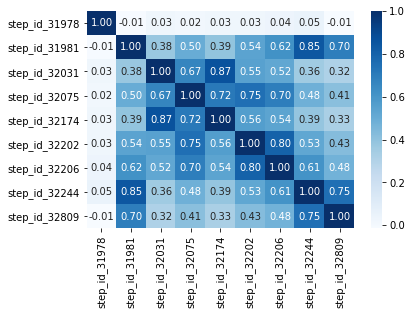

In [47]:
sns.heatmap(get_steps_ohe_features(hard_steps.index, submissions_2d).corr(), annot=True, fmt='.2f', cmap='Blues');

Напоследок, посчитаем долю правильных решений задач для каждого пользователя и некоторые дополнительные признаки. Фича с долей правильных ответов будет, скорее всего, иметь завышенную значимость, так как она единственная вещественнозначная.

In [48]:
def get_correct_ratio(df):
    """
    Создание фичи с долей правильных ответов.
    Если попыток решения не было, то ставим -1.
    """
    df['correct_ratio'] = (df.correct / (df.correct + df.wrong)).fillna(-1)
    
    return df

In [49]:
def get_custom_features(df):
    # отобранные фичи
    df['loss_step'] = df.started_attempt - df.correct # число неверных решений степов 
    df['step_pas'] = df.evn_steps - df.passed # число просмотренных, но не пройденных степов 
    df['all_sum'] = df[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed']].sum(axis=1) # общая активность 
    
    return df

## Датасет со всеми признаками

Теперь присоединим полученные признаки и сгенерируем новый датасет.

In [50]:
def create_work_df(events, submissions, base_features=None, last_action_step_ids=None, last_sub_step_ids=None, ohe_step_ids=None):
    """
    Сборка датасета для работы с моделью

    Parameters
    ----------
    events : pd.DataFrame
        данные с действиями пользователей

    submissions : pd.DataFrame
        данные о попытках решения задач

    base_features : pd.DataFrame, default=None
        таблица с базовыми признаками
        если None, то строится в самой функции

    last_action_step_ids : iterable
        айди степов, для которых проверяем,
        было ли последнее действие пользователей на курсе среди них
        (см. функцию get_last_action_features)

    last_sub_step_ids : iterable
        айди задачных степов, для которых проверяем,
        была ли последняя попытка решить задачу на курсе среди них
        (см. функцию get_last_action_features)

    ohe_step_ids : iterable
        айди задачных степов, для которых проверяем,
        прошли их пользователи или нет

    Returns
    -------
    df : pd.DataFrame
        таблица со сгенерированными признаками
    """

    actions = create_interaction(events, submissions)

    if base_features is not None:
      # загрузить уже посчитанные базовые признаки
      df = base_features
    else:
      df = get_base_features(actions)
    
    df = df.merge(get_actions_difference(actions), on='user_id')

    uniq_hour_evn = get_unique_hours(events, 'uniq_hour_evn')
    uniq_hour_sub = get_unique_hours(submissions, 'uniq_hour_sub')
    df = df.merge(uniq_hour_evn, on='user_id')
    df = df.merge(uniq_hour_sub, on='user_id', how='left').fillna(0)
    
    df = df.merge(get_step_count(submissions, 'sub_steps'), on='user_id', how='left').fillna(0)
    df = df.merge(get_step_count(events, 'evn_steps'), on='user_id')

    if last_action_step_ids is not None:
      df = df.merge(get_last_action_features(last_action_step_ids, actions, 'pop_last_action'), on='user_id')

    if last_sub_step_ids is not None:
      df = df.merge(get_last_action_features(last_sub_step_ids, submissions, 'pop_last_sub'), on='user_id', how='left').fillna(0)

    if ohe_step_ids is not None:
      df = df.merge(get_steps_ohe_features(ohe_step_ids, submissions), on='user_id', how='left').fillna(0)

    df = get_correct_ratio(df)
    df = get_custom_features(df)
    
    return df.fillna(0).set_index('user_id')

In [75]:
train_df_full = create_work_df(events_2d, submissions_2d,
               last_action_step_ids=top_last_actions, last_sub_step_ids=top_last_submissions, ohe_step_ids=hard_steps.index)
train_df_full.head()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,act_diff_day,uniq_hour_evn,uniq_hour_sub,sub_steps,evn_steps,pop_last_action,pop_last_sub,step_id_31978,step_id_31981,step_id_32031,step_id_32075,step_id_32174,step_id_32202,step_id_32206,step_id_32244,step_id_32809,correct_ratio,loss_step,step_pas,all_sum
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,1,0,0,1,-2,1,0.0,0.0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,1,2
2,9,9,2,9,2,0,1,-31,1,1.0,2.0,9,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,31
3,15,15,4,20,4,4,1,-62,2,2.0,4.0,15,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0,0,62
5,1,1,0,1,0,0,1,-3,1,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,3
7,1,1,0,1,0,0,1,-3,1,0.0,0.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0,0,3


С добавлением новых признаков и модель стала сложнее, поэтому лучше немного увеличить максимальную глубину деревьев. Можно попробовать отобрать признаки руками и еще немного поковырять гиперпараметры.

ROC-AUC на тренировочной выборке:	 0.8619898402576933
ROC-AUC на валидационной выборке:	 0.8332265393761077

Mean CV score: 0.8484557096323639
Std of CV scores: 0.014464538659508197


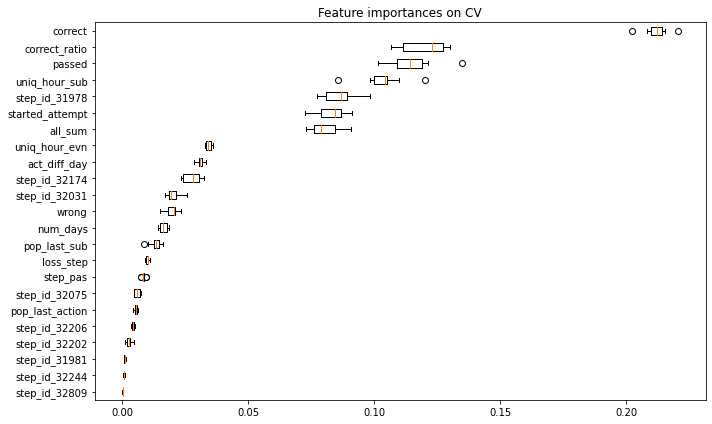

In [78]:
rf.max_depth = 6
rf.n_estimators = 200
rf.min_samples_leaf = 30
rf.min_samples_split = 70
rf.class_weight = 'balanced'
to_drop = ['discovered', 'viewed', 'sub_steps', 'evn_steps']
test_model(rf, train_df_full.drop(columns=to_drop), targets, figsize=(10, 6))

Ну вот, отвоевали пол процента качества, и дисперсия оценок на кросс-валидации почти не изменилась.

## Исправленные данные, отбор юзеров

В соседней тетрадке мы нашли пользователей из тренировочной выборки, у которых были аномальные значения признаков в таблицах ```events_2d``` и ```submissions_2d``` (попытки решения задач без записи ```started_attempt```, слишком большое количество действий в минуту и другие аномалии) и самых подозрительных руками записали как выбросы. Также мы попробовали исправить неправильно залогированные действия пользователей и сохранили новые базовые признаки в отдельную таблицу.

Попробуем выкинуть полученные множества пользователей, исправить датасет и посмотрим, улучшилось ли качество модели.

ROC-AUC на тренировочной выборке:	 0.8610466928675753
ROC-AUC на валидационной выборке:	 0.8386468500443656

Mean CV score: 0.8490041113863358
Std of CV scores: 0.014765323483774056


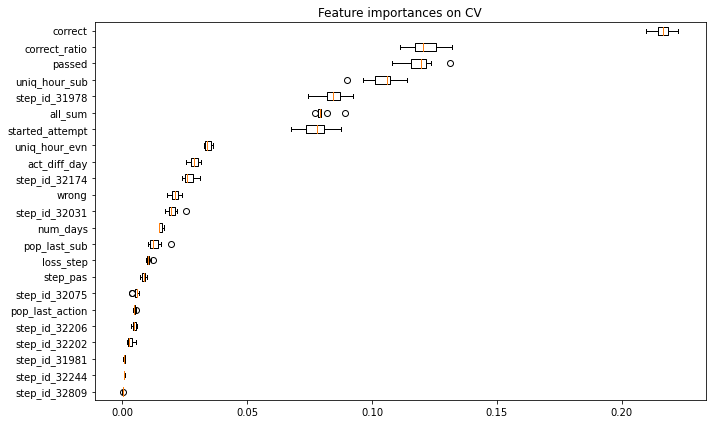

In [80]:
handpicked_outlier_users = np.loadtxt(os.path.join(PATH_TO_DATA, 'handpicked_outlier_users.txt'), dtype=int)

train_df_fixed = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_fixed.csv'), index_col='user_id')

train_df_fixed_full = create_work_df(events_2d, submissions_2d, base_features=train_df_fixed,
                                     last_action_step_ids=top_last_actions, last_sub_step_ids=top_last_submissions, ohe_step_ids=hard_steps.index)

test_model(rf, train_df_fixed_full.drop(index=handpicked_outlier_users, columns=to_drop), targets.drop(index=handpicked_outlier_users), figsize=(10, 6))

Ну совсем немного лучше стало. Иногда будем пользователей выкидывать.

## Неправильно подготовленные данные

Попробуем также поработать с данными, которые получаются неправильной методологией (то есть, будем учитывать первых два дня активности в каждой таблице по отдельности).

In [51]:
submissions_2d_wrong = cut_df_by_time(submissions)
# во второй должно быть больше строчек
print(len(submissions_2d), len(submissions_2d_wrong))

train_df_wrong = get_base_features(create_interaction(events_2d, submissions_2d_wrong))

115466 134612


Проверим, сколько пользователей сделали первый сабмит больше через 2 дня после того, как начали курс (то есть не имеют сабмитов в нашей методологии, но имеют в той, которая описана в курсе).

In [54]:
submissions_2d_wrong_with_timestamps = submissions_2d_wrong.merge(get_min_timestamps(events_2d), on='user_id')

slow_users = np.setdiff1d(
    submissions_2d_wrong_with_timestamps.query('timestamp > min_timestamp + 2 * 24 * 3600').user_id.unique(),
    submissions_2d_wrong_with_timestamps.query('timestamp <= min_timestamp + 2 * 24 * 3600').user_id.unique()
)

del submissions_2d_wrong_with_timestamps

slow_users.shape

(1125,)

А сколько из них окончили?

In [55]:
print(targets[train_df_base.index.isin(slow_users)].value_counts())
del slow_users

passed_course
0                899
1                226
dtype: int64


Этих 226 юзеров априори неправильно будем классифицировать, если использовать методологию выше.

У модели, обученной на неправильно построенных признаках, метрики качества выше. Но это и понятно, эта модель прямо берет данные из будущего.

ROC-AUC на тренировочной выборке:	 0.8929108528576195
ROC-AUC на валидационной выборке:	 0.879870024895729

Mean CV score: 0.8879317921269843
Std of CV scores: 0.0077043421374392304


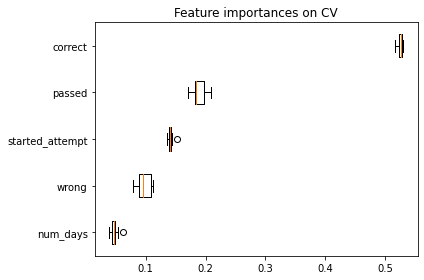

In [ ]:
rf.max_depth = 4
rf.n_estimators = 300
rf.min_samples_leaf = 30
rf.min_samples_split = 70
rf.class_weight = 'balanced'
test_model(rf, train_df_wrong.drop(columns=['discovered', 'viewed']), targets, cv=10)

Посчитаем предсказания этой модели на тестовой выборке.

In [52]:
test_df_wrong = get_base_features(create_interaction(events_test, submissions_test))

In [53]:
def write_predictions(model, X_train, X_test, y_train, pred_name):
  """
  Обучить модель на выборке X_train, y_train,
  сделать предсказания на X_test и записать в файл `pred_name`.csv
  """
  model.fit(X_train, y_train)
  preds = pd.DataFrame(model.predict_proba(X_test)[:, 1], index=X_test.index, columns=['is_gone'])
  preds.to_csv(os.path.join(PATH_TO_DATA, f'{pred_name}.csv'))


In [ ]:
write_predictions(rf,
                  train_df_wrong.drop(index=handpicked_outlier_users, columns=['discovered', 'viewed']),
                  test_df_wrong.drop(columns=['discovered', 'viewed']),
                  targets.drop(index=handpicked_outlier_users), 
                  'pred1') # 0.887

Теперь попробуем обучить модель на полном датасете и отобрать признаки [борутой](https://github.com/scikit-learn-contrib/boruta_py).

In [54]:
train_df_wrong_full = create_work_df(events_2d, submissions_2d_wrong,
               last_action_step_ids=top_last_actions, last_sub_step_ids=top_last_submissions, ohe_step_ids=hard_steps.index)
test_df_wrong_full = create_work_df(events_test, submissions_test,
               last_action_step_ids=top_last_actions, last_sub_step_ids=top_last_submissions, ohe_step_ids=hard_steps.index)

In [55]:
!pip -q install boruta
from boruta import BorutaPy

     |████████████████████████████████| 61kB 3.3MB/s 


In [58]:
rf.max_depth = 6
rf.min_samples_leaf = 30
rf.min_samples_split = 70
rf.n_estimators = 200

feat_selector_rf = BorutaPy(rf, n_estimators=100, verbose=0, random_state=RANDOM_STATE)
feat_selector_rf.fit(train_df_wrong_full.to_numpy(), targets.to_numpy())

print(train_df_wrong_full.columns[feat_selector_rf.support_])
print(train_df_wrong_full.columns[~feat_selector_rf.support_])

Index(['discovered', 'passed', 'started_attempt', 'viewed', 'correct', 'wrong',
       'num_days', 'act_diff_day', 'uniq_hour_evn', 'uniq_hour_sub',
       'sub_steps', 'evn_steps', 'pop_last_sub', 'step_id_31978',
       'step_id_32031', 'step_id_32075', 'step_id_32174', 'step_id_32202',
       'step_id_32206', 'correct_ratio', 'loss_step', 'step_pas', 'all_sum'],
      dtype='object')
Index(['pop_last_action', 'step_id_31981', 'step_id_32244', 'step_id_32809'], dtype='object')


ROC-AUC на тренировочной выборке:	 0.9034771165972105
ROC-AUC на валидационной выборке:	 0.8892242937637227

Mean CV score: 0.893171851604446
Std of CV scores: 0.007510028919468407


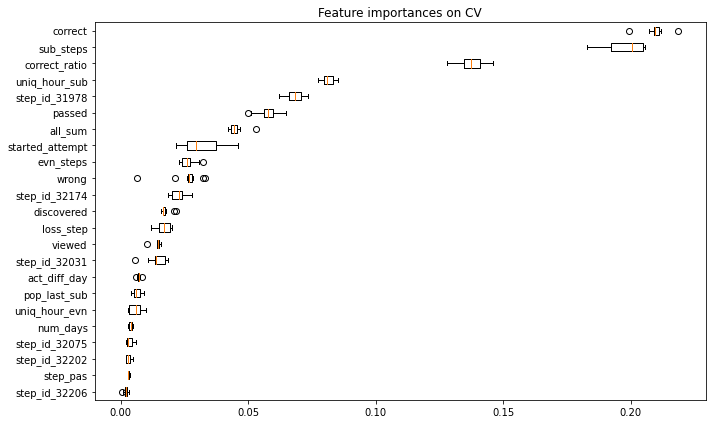

In [73]:
test_model(rf, train_df_wrong_full.loc[:, feat_selector_rf.support_], targets, cv=10, figsize=(10, 6))

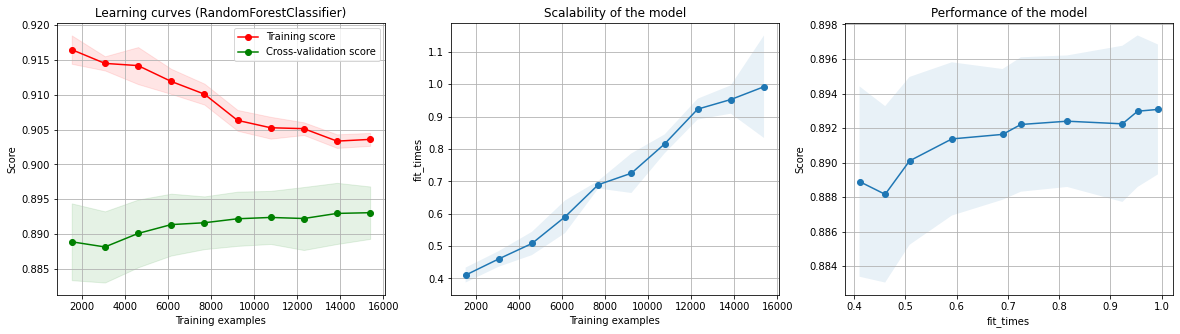

In [ ]:
plot_learning_curve(rf, train_df_wrong_full.loc[:, feat_selector_rf.support_], targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

Посмотрим на интерпретацию полученной модели с помощью SHAP values:

In [56]:
!pip -q install shap
from shap import TreeExplainer, summary_plot

     |████████████████████████████████| 358kB 4.2MB/s 


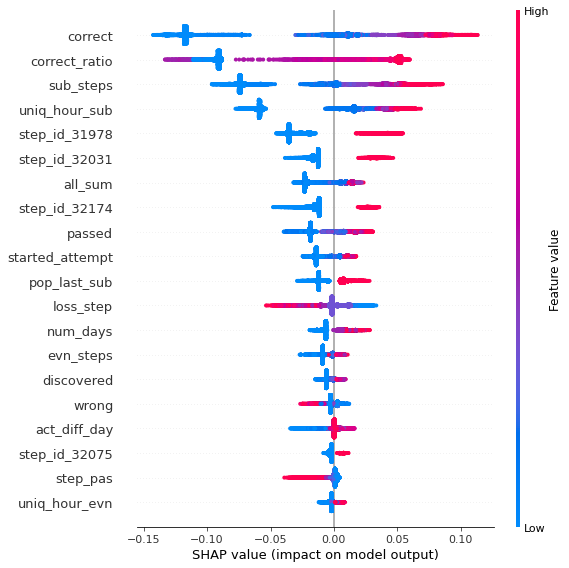

In [71]:
rf.fit(train_df_wrong_full.loc[:, feat_selector_rf.support_], targets)
explainer_rf = TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(train_df_wrong_full.loc[:, feat_selector_rf.support_], targets)
summary_plot(shap_values_rf[1], features=train_df_wrong_full.loc[:, feat_selector_rf.support_], class_inds=[1])

Ну, выглядит разумно, в том плане что значения фичей коррелируют с их shap values. Хотя не ясно, shap values тоже не очень точно работают для коррелирующих признаков.

In [ ]:
write_predictions(rf,
                  train_df_wrong_full.loc[:, feat_selector_rf.support_],
                  test_df_wrong_full.loc[:, feat_selector_rf.support_],
                  targets, 
                  'pred2') # 0.889

## Бонус: XGBoost, Shap, Optuna

Попробуем также обучить бустинг на деревьях для этой задачи.

In [57]:
import xgboost as xgb

Посмотрим, что за модель получится при "дефолтных" значениях параметров бустинга.

ROC-AUC на тренировочной выборке:	 0.9146045877147371
ROC-AUC на валидационной выборке:	 0.8928528389067043

Mean CV score: 0.8837634535519804
Std of CV scores: 0.010754413873184336


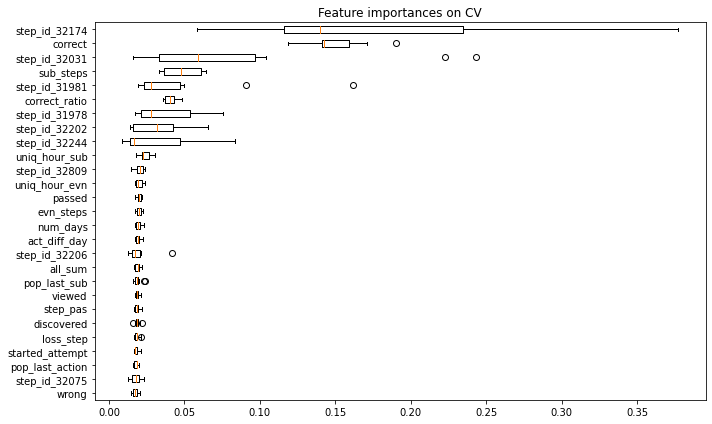

In [59]:
xgb_params = dict(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=4,
    tree_method='exact',
    booster='gbtree',
    subsample=0.6,
    colsample_bytree=1,
    min_child_weight=1,
    seed=RANDOM_STATE
)

xgb_fit_params = dict(
    eval_metric='auc',
    early_stopping_rounds=20,
    verbose=0,
)

bst = xgb.XGBClassifier(**xgb_params)

test_model(bst, train_df_wrong_full, targets, fit_params=xgb_fit_params, random_state=RANDOM_STATE, cv=10, figsize=(10, 6))

Очень большой разброс значимостей у признаков, связанных с шагами. Видимо, это получается из-за того, что они сильно между собой коррелируют (в случайном лесе каждое дерево не видит все эти фичи одновременно, поэтому и разброс значимостей меньше?):

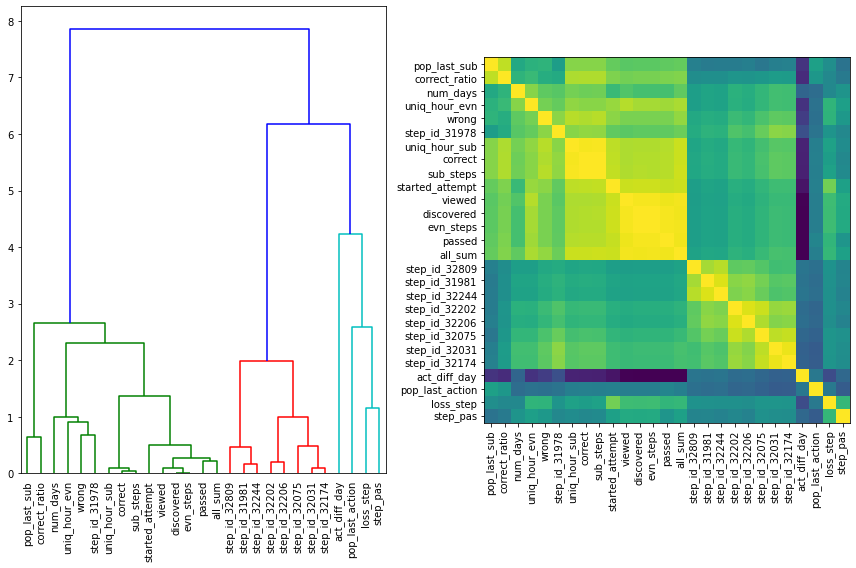

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = stats.spearmanr(train_df_wrong_full).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=train_df_wrong_full.columns.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

Кажется, для этой модели проще всего будет избавиться от набора фичей, связанных с шагами (можно оставить одну или две из этого набора, но это не повлияет на качество).

In [61]:
hard_step_features = ['step_id_' + str(step_id) for step_id in hard_steps.index.tolist()]
train_df_wrong_sel = train_df_wrong_full.drop(columns=hard_step_features)
test_df_wrong_sel = test_df_wrong_full.drop(columns=hard_step_features)

Эта модель довольно сильно переобучается, но все равно дает хороший результат на тестовом множестве:

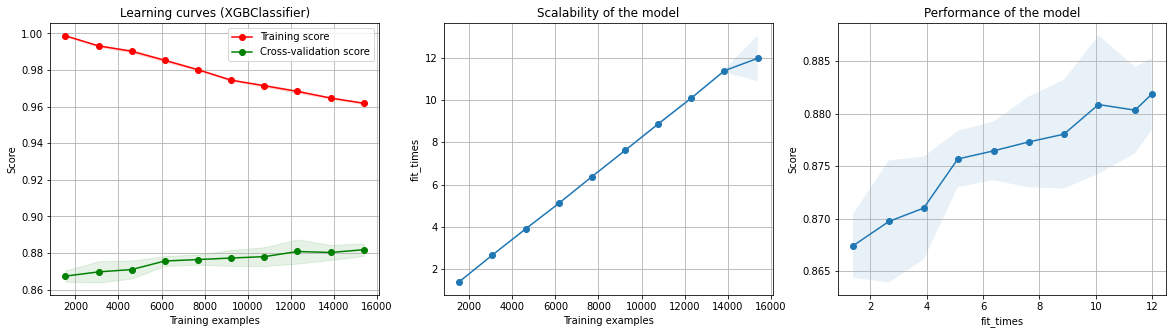

In [76]:
plot_learning_curve(bst, train_df_wrong_sel, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df_wrong_sel, targets, test_size=0.1, random_state=RANDOM_STATE)
xgb_fit_params['eval_set'] = [(X_valid, y_valid)]
bst.fit(X_train, y_train, **xgb_fit_params)
preds_bst = pd.DataFrame(bst.predict_proba(test_df_wrong_sel)[:, 1], index=test_df_wrong_sel.index, columns=['is_gone'])
preds_bst.to_csv(os.path.join(PATH_TO_DATA, 'pred_xgb1.csv')) # 0.886

Здесь явно какие-то признаки переобучают модель сильнее, чем в случайном лесу, так что надо их как-то отобрать. Было попробовано три варианта сделать это:
1. Продолжить рассуждения с кластеризацией признаков через их корреляцию, построить кластеры и выбрать из каждого только один признак, как делается [тут](https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance_multicollinear.html);
2. Отобрать фичи, на которых модель достигает наибольшего качества, с помощью [sequential feature selector](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) (вообще не ясно, насколько это хорошая практика);
3. Отобрать признаки с помощью боруты.

Лучше всего оказывается третий подход.

In [79]:
feat_selector_xgb = BorutaPy(bst, n_estimators=100, verbose=0, random_state=RANDOM_STATE)
feat_selector_xgb.fit(X_train.to_numpy(), y_train.to_numpy())

selected_features_brt = train_df_wrong_sel.columns[feat_selector_xgb.support_]
print(selected_features_brt)

Index(['passed', 'correct', 'num_days', 'act_diff_day', 'uniq_hour_evn',
       'uniq_hour_sub', 'sub_steps', 'pop_last_sub', 'correct_ratio'],
      dtype='object')


In [63]:
feat_selector_xgb = BorutaPy(bst, n_estimators=100, verbose=0, random_state=RANDOM_STATE)
feat_selector_xgb.fit(X_train.to_numpy(), y_train.to_numpy())

selected_features_brt = train_df_wrong_sel.columns[feat_selector_xgb.support_]
print(selected_features_brt)

Index(['passed', 'correct', 'num_days', 'act_diff_day', 'uniq_hour_evn',
       'uniq_hour_sub', 'sub_steps', 'pop_last_sub', 'correct_ratio'],
      dtype='object')


In [64]:
train_df_wrong_sel = train_df_wrong_sel.loc[:, selected_features_brt]
test_df_wrong_sel = test_df_wrong_sel.loc[:, selected_features_brt]

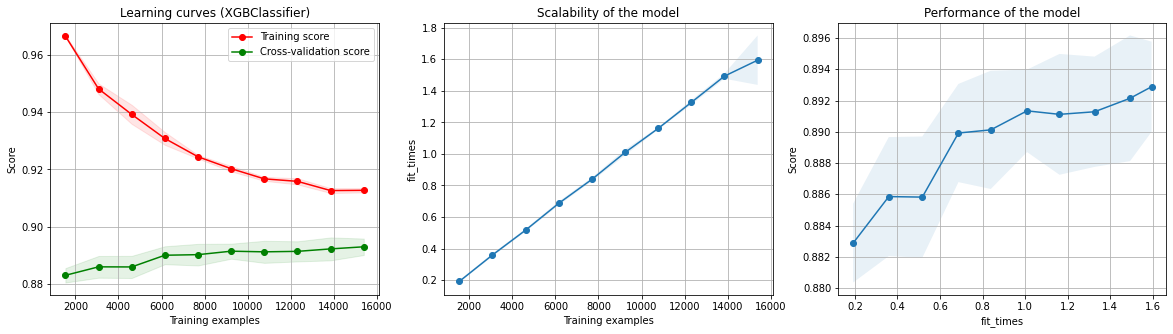

In [81]:
plot_learning_curve(bst, train_df_wrong_sel, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

ROC-AUC на тренировочной выборке:	 0.8999775131289265
ROC-AUC на валидационной выборке:	 0.8914302258251304

Mean CV score: 0.8931156032429561
Std of CV scores: 0.008993396414513778


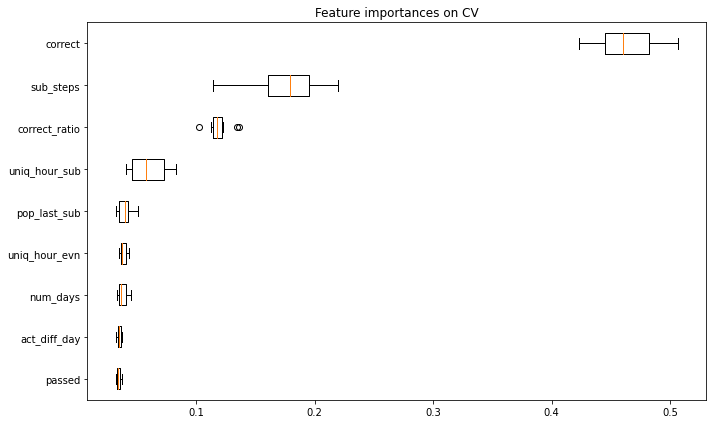

In [82]:
xgb_fit_params = dict(
    eval_metric='auc',
    early_stopping_rounds=20,
    verbose=0,
)
test_model(bst, train_df_wrong_sel, targets, fit_params=xgb_fit_params, random_state=RANDOM_STATE, cv=10, figsize=(10, 6))

In [85]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df_wrong_sel, targets, test_size=0.1, random_state=RANDOM_STATE)
xgb_fit_params['eval_set'] = [(X_valid, y_valid)]
bst.fit(X_train, y_train, **xgb_fit_params)
preds_bst = pd.DataFrame(bst.predict_proba(test_df_wrong_sel)[:, 1], index=test_df_wrong_sel.index, columns=['is_gone'])
preds_bst.to_csv(os.path.join(PATH_TO_DATA, 'pred_xgb2.csv')) # 0.888

Посмотрим на shap values этой модели:

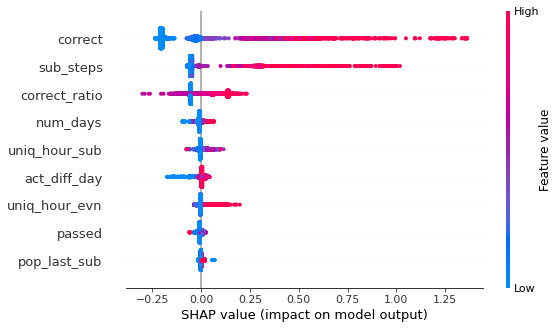

In [94]:
bst.fit(X_train, y_train)
explainer_bst = TreeExplainer(bst)
shap_values_bst = explainer_bst.shap_values(X_train, y_train)
summary_plot(shap_values_bst, features=X_train, class_inds=[1])

Так как деревья в бустингу видят сразу все фичи одновременно, то больший вес отходит на фичу ```correct```, что разумно, в общем-то. А так только фича ```correct_ratio``` странно себя ведет.

Попробуем настроить гиперпараметры с помощью ```optuna```. Будем проводить оптимизацию на кросс-валидации с 10 фолдами и ранней остановкой через ```xgb.cv``` и оптимизировать метрику ```test-auc-mean - test-auc-std```. 

In [65]:
!pip -q install optuna
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna import create_study
from optuna.pruners import HyperbandPruner

     |████████████████████████████████| 296kB 4.2MB/s 
     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 1.2MB 7.0MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 112kB 13.9MB/s 
     |████████████████████████████████| 143kB 12.4MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 


In [66]:
def objective(trial, X=train_df_wrong_full, y=targets):

  dtrain = xgb.DMatrix(data=X, label=y)

  # задаем сетку параметров, которые будем оптимизировать
  param = {
      "verbosity": 0,
      "objective": "binary:logistic",
      "eval_metric": "auc",
      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
      "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
      "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
      }

  if param["booster"] == "gbtree" or param["booster"] == "dart":
      param["max_depth"] = trial.suggest_int("max_depth", 1, 4)
      param["learning_rate"] = trial.suggest_float("learning_rate", 1e-8, 1.0, log=True)
      param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
      param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

      param["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 20)
      # param["scale_pos_weight"] = trial.suggest_int("scale_pos_weight", 1, 10)
      param["subsample"] = trial.suggest_loguniform('subsample', 0.6, 1.0)
      param['colsample_bytree'] = trial.suggest_loguniform('colsample_bytree', 0.6, 1.0)


  if param["booster"] == "dart":
      param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
      param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
      param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
      param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

  # 10 фолдов, ранняя остановка, если результат на тесте не улучшается
  # в течение 10 эпох. Также можем прервать trial через Hyperband pruner,
  # смотри следующую ячейку.
  pruning_callback = XGBoostPruningCallback(trial, "test-auc")
  xgb_cv_fit_params = dict(
    num_boost_round=500,
    nfold=10,
    stratified=True,
    metrics='auc',
    early_stopping_rounds=10,
    callbacks=[pruning_callback],
    seed=RANDOM_STATE,
  ) 

  xgb_cv_results = xgb.cv(param, dtrain, **xgb_cv_fit_params)

  trial.set_user_attr('n_estimators', len(xgb_cv_results))

  result = (xgb_cv_results["test-auc-mean"] - xgb_cv_results["test-auc-std"]).max()
  return result

In [71]:
pruner = HyperbandPruner()
study = create_study(pruner=pruner, direction="maximize")
study.optimize(objective, n_trials=100, timeout=3600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
xgb_params = dict(**trial.user_attrs, **trial.params)
bst.set_params(**xgb_params)
for key, value in xgb_params.items():
  print("    {}: {}".format(key, value))

[I 2021-05-19 06:37:37,834] A new study created in memory with name: no-name-788d4e16-9983-4294-8dae-7d36f5bfcd16
[I 2021-05-19 06:37:58,730] Trial 0 finished with value: 0.775762465014286 and parameters: {'booster': 'dart', 'lambda': 0.004383649587421951, 'alpha': 0.0292552231776898, 'max_depth': 1, 'learning_rate': 3.749644867162064e-06, 'gamma': 0.00011170047712229219, 'grow_policy': 'depthwise', 'min_child_weight': 9, 'subsample': 0.8390990211787378, 'colsample_bytree': 0.698465913221769, 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 6.689727483942279e-06, 'skip_drop': 6.931125358822596e-08}. Best is trial 0 with value: 0.775762465014286.
[I 2021-05-19 06:38:11,383] Trial 1 finished with value: 0.8833792576317845 and parameters: {'booster': 'gbtree', 'lambda': 7.295050081015124e-06, 'alpha': 1.477559763933558e-06, 'max_depth': 4, 'learning_rate': 0.08456962779029455, 'gamma': 0.001566646914714386, 'grow_policy': 'depthwise', 'min_child_weight': 7, 'subsample': 0

Number of finished trials: 100
Best trial:
  Value: 0.8848064662089087
  Params: 
    n_estimators: 78
    booster: gbtree
    lambda: 3.272257566486546e-05
    alpha: 0.004282851407256613
    max_depth: 3
    learning_rate: 0.13381487353363408
    gamma: 0.014726710303553426
    grow_policy: lossguide
    min_child_weight: 15
    subsample: 0.6885325534908724
    colsample_bytree: 0.7606674558732408


При этих параметрах получаются странные результаты: если смотреть по кривым обучения, то переобучения меньше, а если по графикам значимостей переменных, то разбросы значимостей становятся больше. Не знаю, как это интерпретировать сходу, может быть, задали слишком много гиперпараметров для оптимизации.

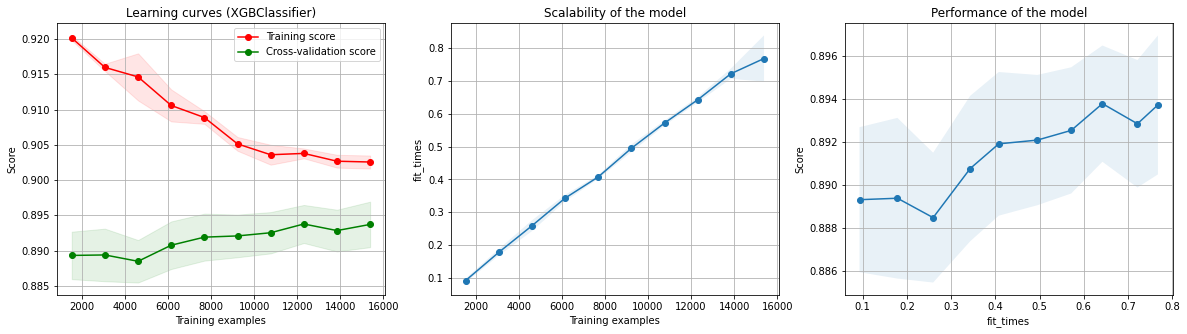

In [74]:
plot_learning_curve(bst, train_df_wrong_sel, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

ROC-AUC на тренировочной выборке:	 0.901052453983979
ROC-AUC на валидационной выборке:	 0.890266269667479

Mean CV score: 0.8943378166230278
Std of CV scores: 0.00752711384869829


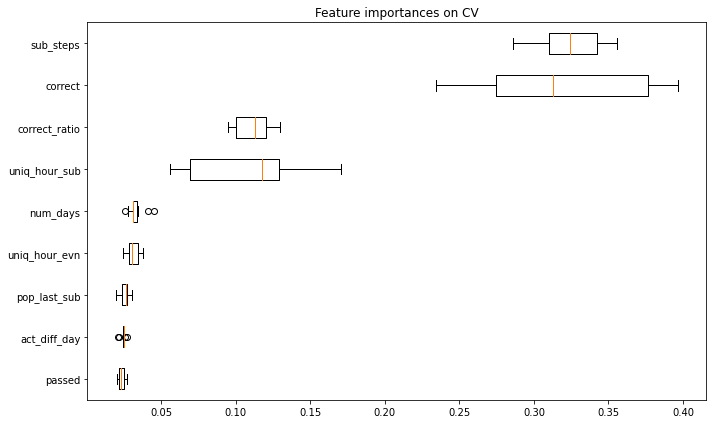

In [72]:
xgb_fit_params = dict(
    eval_metric='auc',
    early_stopping_rounds=20,
    verbose=0,
)
test_model(bst, train_df_wrong_sel, targets, fit_params=xgb_fit_params, random_state=RANDOM_STATE, cv=10, figsize=(10, 6))

Качество на тестовой выборке получается такое же, как без настройки гиперпараметров:

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df_wrong_sel, targets, test_size=0.1, random_state=RANDOM_STATE)
xgb_fit_params['eval_set'] = [(X_valid, y_valid)]
bst.fit(X_train, y_train, **xgb_fit_params)
preds_bst = pd.DataFrame(bst.predict_proba(test_df_wrong_sel)[:, 1], index=test_df_wrong_sel.index, columns=['is_gone'])
preds_bst.to_csv(os.path.join(PATH_TO_DATA, 'pred_xgb3.csv')) # 0.889

## Что можно доделать:
- Все еще не хватает отбора признаков и их интерпретации не вслепую — это вообще непросто, когда много коррелирующих переменных, поскольку все известные мне методы (нативные ```feature_importances_``` в древесных моделях, permutation importances и SHAP values) распределяют важности между коррелирующими фичами. Возможно, нужно перемешивать кластеры коррелирующих фичей одновременно?

- Видимо, случайный лес настроить проще, чем бустинг. Возможно, поскольку датасет не очень большой, мы все же немного переобучаемся на бустинге? Не ясно, как интерпретировать большой разброс в значимостях фичей. Скорее всего, нужно сужать сетку гиперпараметров для бустинга.

